In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
 
def get_sales(dept_num, item_num, store_id): 
    df_train = pd.read_csv('./data/df_train 결측치 제거.csv', index_col=0) # 본인 파일 경로로 수정해야함
    tmp = df_train[df_train['cat_id'] == 'FOODS'] # df_train에서 카테고리가 식품인 것만 마스킹
    

    if len(str(item_num)) == 1: # item_num 글자수에 따라 자릿수 3자리 맞춰주기 (8 -> 008)
        tmp = df_train[df_train['item_id'] == f'FOODS_{dept_num}_00{item_num}']
    elif len(str(item_num)) == 2:
        tmp = df_train[df_train['item_id'] == f'FOODS_{dept_num}_0{item_num}']
    else:
        tmp = df_train[df_train['item_id'] == f'FOODS_{dept_num}_{item_num}']

    d_ = [col for col in df_train.columns if "d_" in col]
    store_sales = tmp.groupby('store_id')[d_].sum().T # 주별로 그룹
    store_sales = store_sales.iloc[:1908,:]
    return store_sales[store_id].values # 입력한 주의 판매량만 반환

def predict_item_id_sales(store_id, dept_num, item_id, weekday, event, Temperatures, pop, unemployment_rate, gcv):
    if (dept_num > 3) or (item_id < 1) or(dept_num == 1 and item_id > 219) or (dept_num == 2 and item_id > 399) or (dept_num == 3 and item_id > 827):
        raise Exception('범위 에러: FOODS_1은 1~ 219, FOODS_2은 1~ 399, FOODS_3은 1~ 827 으로 다시 입력해주세요.')
    
    X_train = pd.read_csv('./data/X_train.csv', index_col=0) # 본인 파일 경로로 수정해야함
    state = X_train[X_train['state_id'] == store_id[:2]]
    X = state[['weekday','event','평균기온', '매장당평균인구수', '실업률']]
    y= [i for i in get_sales(dept_num, item_id, store_id)]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=13)

    lr1 = GradientBoostingRegressor(random_state=13)
    if gcv==0:
        params = {"max_depth" : [3], #5,7,10
                "learning_rate" : [0.1,0.2], #0.3,0.4,0.5
                "n_estimators" : [50,65]#,80,100,150
                }
        model = GridSearchCV(estimator = lr1, param_grid = params, scoring='r2', cv = 3, n_jobs=-1, verbose=1)
        model.fit(X_train, y_train)
        #Graph
        y_pred_g = model.predict(X_test)
        y_pred_g = list(y_pred_g)
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=y_test, y=y_pred_g)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', ls='--', lw=1)
        plt.xlabel('실제 판매량')
        plt.ylabel('예측 판매량')
        plt.show()
       
        y_pred = model.predict(pd.DataFrame(data={'weekday': [weekday, weekday], 'event':[event, event], '평균기온': [Temperatures, Temperatures], '매장당평균인구수': [pop, pop], '실업률': [unemployment_rate, unemployment_rate]}))
        print(f' 최적 learning_rate: {model.best_params_["learning_rate"]}')
        print(f' 최적 max_depth: {model.best_params_["max_depth"]}')
        print(f' 최적 n_estimators: {model.best_params_["n_estimators"]}')
    else: 
        model = GradientBoostingRegressor(learning_rate=gcv[0], max_depth=gcv[1], n_estimators=gcv[2], random_state=13).fit(X_train, y_train)
        #Graph
        y_pred_g = model.predict(X_test)
        y_pred_g = list(y_pred_g)
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=y_test, y=y_pred_g)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', ls='--', lw=1)
        plt.xlabel('실제 판매량')
        plt.ylabel('예측 판매량')
        plt.show()

        
        y_pred = model.predict(pd.DataFrame(data={'weekday': [weekday, weekday], 'event':[event, event], '평균기온': [Temperatures, Temperatures], '매장당평균인구수': [pop, pop], '실업률': [unemployment_rate, unemployment_rate]}))

        
    return round(y_pred[0])


In [10]:
def print_result():
    print('===========================================')
    print('안녕하세요 판매량 예측 모델, 판담입니다.')
    print('특정 일의 판매량 예측을 위한 8가지 질문을 시작하겠습니다.')
    print('')

    print('1번) CA, TX, WI 중 원하시는 주를 입력해주세요.')
    state_id = input('주 입력 : ').upper()
    
    if state_id == 'CA':
        print('1번) 1 ~ 4 중 원하시는 지점 번호를 입력해주세요.')
        store_num = input('지점 번호 입력 : ')
        
    else:
        print('1번) 1 ~ 3 중 원하시는 지점 번호를 입력해주세요.')
        store_num = input('지점 번호 입력 : ')
        
    store_id = state_id + '_' + store_num 
    print('')

    print('2번) 1 ~ 3 중 원하시는 식품 분류 번호를 입력해주세요.')
    dept_num = int(input('식품 분류 번호 입력 : '))
    print('')

    if dept_num==1:
        print('3번) 1 ~ 219 중 원하시는 식품 id를 입력해주세요.')
        item_id = int(input('식품 id 입력 : '))

    elif dept_num==2:
        print('3번) 1 ~ 399 중 원하시는 식품 id를 입력해주세요.')
        item_id = int(input('식품 id 입력 : '))

    elif dept_num==3:
        print('3번) 1 ~ 827 중 원하시는 식품 id를 입력해주세요.')
        item_id = int(input('식품 id 입력 : '))
    else : raise Exception('범위 에러: FOODS_1은 1~ 219, FOODS_2은 1~ 399, FOODS_3은 1~ 827 으로 다시 입력해주세요.')
    print('')

    print('4번) 평일->0, 주말->1 중 원하시는 날짜의 구분 숫자를 입력해주세요.')
    weekday = int(input('평일/주말 구분 숫자 입력 : '))
    print('')

    print('5번) 일반->0, 행사->1 중 원하시는 날짜의 행사유무 숫자를 입력해주세요.')
    event = int(input('행사 유무 숫자 입력 : '))
    print('')

    print('6번) 원하시는 날짜의 기온을 입력해주세요.')
    Temperatures = int(input('기온 입력(°C): '))
    print('')

    print('7번) 원하시는 날짜의 매장 당 인구 수를 입력해주세요.')
    pop = int(input('매장 당 인구 입력(명): '))
    print('')

    print('8번) 원하시는 날짜의 실업률을 입력해주세요.')
    unemployment_rate = int(input('실업률 입력(%): '))
    print('')

    gcv = [float(input('10-1번) learning_rate 입력해주세요.: ')), int(input('10-2번) max_depth 입력해주세요.: ')), int(input('10-2번) n_estimators 입력해주세요.: '))] if int(input('10번) 모델 파라미터를 입력해주세요.(미입력: 0, 입력:1): ')) == 1 else 0
    
    print('========= 결과 출력 중 잠시만 기다려주세요.===========')
    print('')
    result = predict_item_id_sales(store_id, dept_num, item_id, weekday, event, Temperatures, pop, unemployment_rate, gcv)
    print(f'입력하신 조건에 해당하는 일의 {store_id}지점 food_{dept_num}_{item_id} 판매량은 {result}입니다.')
    print('')
    print('이용해주셔서 감사합니다.')
    print('===========================================')


안녕하세요 판매량 예측 모델, 판담입니다.
특정 일의 판매량 예측을 위한 8가지 질문을 시작하겠습니다.

1번) CA, TX, WI 중 원하시는 주를 입력해주세요.
1번) 1 ~ 4 중 원하시는 지점 번호를 입력해주세요.

2번) 1 ~ 3 중 원하시는 식품 분류 번호를 입력해주세요.

3번) 1 ~ 827 중 원하시는 식품 id를 입력해주세요.

4번) 평일->0, 주말->1 중 원하시는 날짜의 구분 숫자를 입력해주세요.

5번) 일반->0, 행사->1 중 원하시는 날짜의 행사유무 숫자를 입력해주세요.

6번) 원하시는 날짜의 기온을 입력해주세요.

7번) 원하시는 날짜의 매장 당 인구 수를 입력해주세요.

8번) 원하시는 날짜의 실업률을 입력해주세요.

========= 결과 출력 중 잠시만 기다려주세요.===========

Fitting 3 folds for each of 4 candidates, totalling 12 fits


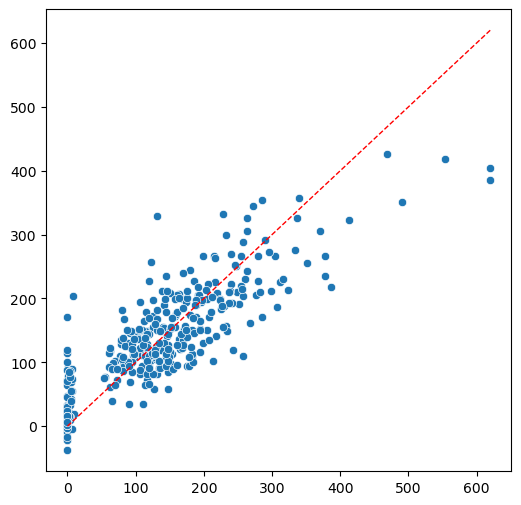

 최적 learning_rate: 0.2
 최적 max_depth: 3
 최적 n_estimators: 65
입력하신 조건에 해당하는 일의 CA_3지점 food_3_90 판매량은 130입니다.

이용해주셔서 감사합니다.


In [35]:
# predict_item_id_sales(CA, 3, 3, 90, 1, 1, 30, 120800, 10, 0)
print_result()